# 1. Quantized model 

In [1]:
import os
import time
import torch
import pandas as pd
import numpy as np
from torch import nn
from torch.utils.data import DataLoader, Dataset
from sklearn.model_selection import KFold
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score, confusion_matrix
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, fbeta_score, confusion_matrix
from torch.optim.lr_scheduler import ReduceLROnPlateau
from sklearn.svm import SVC
from sklearn.neural_network import MLPClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split
from torch.utils.data import TensorDataset
import random
import pickle
import sys
# !pip install qnet
sys.path.insert(0, os.path.abspath('../'))
from qnet import *
from calflops import calculate_flops

In [2]:
class Args:
    data_path = '/home/sebastian/codes/repo_clean/VE_paper/0_VE_extraction/E_NET_EMBEDDINGS/urban8k_efficientnet_b3/efficientnet_b3_1536_bs64'
    output_dir = 'results_jan_28'
    total_num_seed = 3
    num_classes = 5
    num_epochs = 3
    batch_size = 64
    learning_rate = 1e-3
    model = 'mlp'
    device = 'cpu'#'cuda' if torch.cuda.is_available() else 'cpu'
    pca = False
    variance_threshold = 0.8

args = Args()

# Fix paths to use current working directory
device = torch.device(args.device)
print(f"Using device: {device}")

Using device: cpu


SEED 0
--------------------------------
Train data: /home/sebastian/codes/repo_clean/VE_paper/0_VE_extraction/E_NET_EMBEDDINGS/urban8k_efficientnet_b3/efficientnet_b3_1536_bs64/train_embeddings.csv
Val data: /home/sebastian/codes/repo_clean/VE_paper/0_VE_extraction/E_NET_EMBEDDINGS/urban8k_efficientnet_b3/efficientnet_b3_1536_bs64/val_embeddings.csv
---------------------Embeddings shapes----------------------
Training: X: torch.Size([7488, 1536]) - y: torch.Size([7488])
Validation: X: torch.Size([836, 1536]) - y: torch.Size([836])
Reset trainable parameters of layer = Linear(in_features=1536, out_features=256, bias=True)
Reset trainable parameters of layer = LayerNorm((256,), eps=1e-05, elementwise_affine=True)
Reset trainable parameters of layer = Linear(in_features=256, out_features=128, bias=True)
Reset trainable parameters of layer = LayerNorm((128,), eps=1e-05, elementwise_affine=True)
Reset trainable parameters of layer = Linear(in_features=128, out_features=64, bias=True)
Reset 

[W129 06:16:23.267096729 CPUAllocator.cpp:249] Memory block of unknown size was allocated before the profiling started, profiler results will not include the deallocation event


total_cpu_memory_train (MB):  3347.2544860839844
total_cpu_memory_inference (MB):  18.42095947265625
total_cpu_memory (MB):  3365.6754455566406
Training time: 1.54 seconds
Inference time: 0.02 seconds
{'EMB_size_out': 1536, 'Accuracy': 0.7954545454545454, 'F1 Score': 0.790060427415814, 'F0.75 Score': 0.7911363689691718, 'Precision': 0.8011362659180951, 'Recall': 0.7954545454545454, 'Training time': 1.541348934173584, 'Inference time': 0.023548126220703125, 'Mem. Train (MB)': 3347.2544860839844, 'Mem. Infer (MB)': 18.42095947265625, 'Total. RAM': 3365.6754455566406}
Model saved in: /home/sebastian/codes/repo_clean/VE_paper/1_Classification/results_jan_28/mlp_efficientnet_b3_1536_bs64_quantized_model/seed_0/mlp_efficientnet_b3_1536_bs64_quantized_model_0.pkl
Failed to pickle the model due to: cannot pickle 'module' object
SEED 1
--------------------------------
Train data: /home/sebastian/codes/repo_clean/VE_paper/0_VE_extraction/E_NET_EMBEDDINGS/urban8k_efficientnet_b3/efficientnet_b3_1

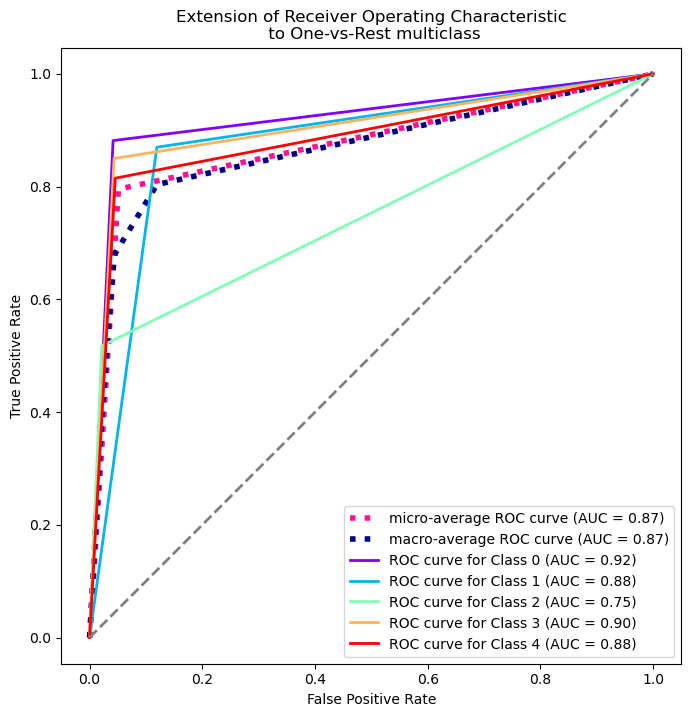

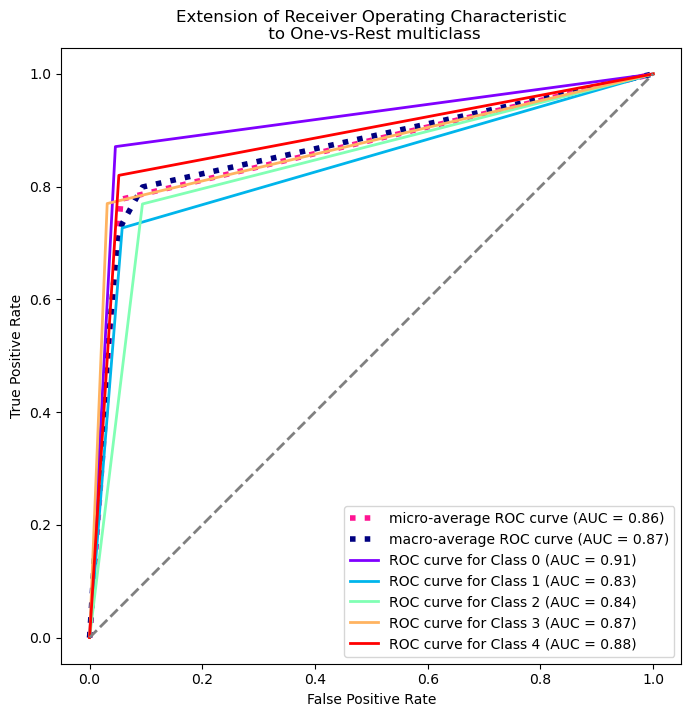

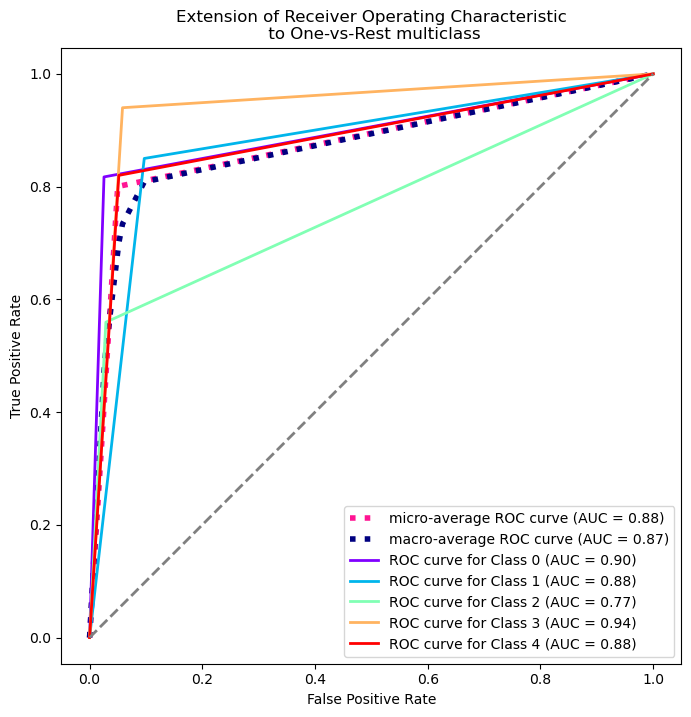

In [3]:
quantized = True

for seed in range(args.total_num_seed):
    print(f'SEED {seed}')
    print('--------------------------------')
    torch.manual_seed(seed)
    np.random.seed(seed)
    
    train_csv = os.path.join(args.data_path, 'train_embeddings.csv')
    val_csv = os.path.join(args.data_path, 'val_embeddings.csv')
    print(f"Train data: {train_csv}")
    print(f"Val data: {val_csv}")
    
    experiment_folder = f"{args.model}_{args.data_path.split('/')[-1]}"
    experiment_folder += f"_quantized_model"
    # Create output directories
    output_folder = os.path.join(os.getcwd(), args.output_dir, experiment_folder)
    seed_dir = os.path.join(output_folder, f"seed_{seed}")
    os.makedirs(seed_dir, exist_ok=True)
    
    # Load datasets
    train_dataset = EmbeddingDataset(train_csv, shuffle=True)
    val_dataset = EmbeddingDataset(val_csv, shuffle=False)
    
    X_train, y_train = train_dataset.features, train_dataset.labels
    X_val, y_val = val_dataset.features, val_dataset.labels
    
    print(f"Embeddings shapes".center(60,"-"))
    print(f"Training: X: {X_train.shape} - y: {y_train.shape}\nValidation: X: {X_val.shape} - y: {y_val.shape}")

    train_loader = DataLoader(train_dataset, batch_size=args.batch_size, shuffle=True)
    val_loader = DataLoader(val_dataset, batch_size=args.batch_size, shuffle=False)

    class_counts = np.bincount(np.asarray(y_train, int))
    class_weights = 1.0 / class_counts
    class_weights = torch.tensor(class_weights, dtype=torch.float32)
    num_columns = X_train.shape[1]
    patience = 50  
    best_f1 = 0.0
    patience_counter = 0    
    
    class_weights = class_weights.to(device)
    original_model = SClassifier(train_dataset.features.shape[1], args.num_classes, hidden_sizes=[256, 128, 64]).to(device)
    original_model.apply(reset_weights)
        
    # Train Model with Profiler
    with profile(activities=[ProfilerActivity.CPU], profile_memory=True, record_shapes=True) as prof_train:
            start_train_time = time.time()
            model_trained, train_losses, val_losses = train_pytorch(args, original_model, train_loader, val_loader, class_weights, num_columns, device,seed_dir)
            end_train_time = time.time()
            end_train_time = time.time()
            model_memory = get_memory_usage()
    total_cpu_memory_train = sum(event.cpu_memory_usage for event in prof_train.key_averages())/(1024 * 1024)
    
    if quantized:
            print("quantized original_model")
            model_quantized = torch.quantization.quantize_dynamic(
                    model_trained,
                    {nn.Linear},
                    dtype=torch.qint8
            )
            model_quantized.eval()
            for param in model_quantized.parameters():
                param.requires_grad_(False)
    else:
                original_model = model_trained
    
    # Eval. Model with Profiler
    with profile(activities=[ProfilerActivity.CPU], profile_memory=True, record_shapes=True) as prof_eval:
        start_inference_time = time.time()
        all_labels, all_preds = eval_pytorch_model(model_quantized, val_loader, device)
        end_inference_time = time.time()

    # Get total CPU memory usage during inference
    total_cpu_memory_inference = sum(event.cpu_memory_usage for event in prof_eval.key_averages())/(1024 * 1024)
    # print(prof_eval.key_averages().table(sort_by="self_cpu_memory_usage", row_limit=10))

    training_time = end_train_time - start_train_time
    inference_time = end_inference_time - start_inference_time

    # Update memory with the sum of training and inference memory usage
    print("total_cpu_memory_train (MB): ", total_cpu_memory_train)
    print("total_cpu_memory_inference (MB): ", total_cpu_memory_inference)

    metrics = get_all_metrics(X_train.shape[1], all_labels, all_preds, total_cpu_memory_train, total_cpu_memory_inference, training_time, inference_time)  # Convert to MB

    print(f'Training time: {training_time:.2f} seconds')
    print(f'Inference time: {inference_time:.2f} seconds')
    print(metrics)
    
    save_predictions(seed_dir, experiment_folder, model, metrics, all_labels, all_preds, seed)
    plot_multiclass_roc_curve(all_labels, all_preds, seed_dir)
    save_confusion_matrix(all_labels, all_preds, np.unique(y_train), seed_dir, "val")

consolidate_and_average_metrics(args, output_folder)
print("Evaluation across different seeds completed. Results saved to the output directory.")

# Calculate flops, macs, params

In [7]:
# flops, macs, params = calculate_flops(model=model_quantized, 
#                                       input_shape=(1, train_dataset.features.shape[1]),
#                                       output_as_string=True,
#                                       output_precision=4)

# results = {'KFLOPS':flops/1e3,
#             'KMACS':macs/1e3,
#             'KPARAMS':params/1e3}
# print(results)

In [8]:
import torch
from calflops import calculate_flops
input_shape = (1, train_dataset.features.shape[1])  # Assuming X_train is defined and has the correct shape

dummy_input = torch.randn(input_shape).to(device)  # Random tensor with the appropriate shape

original_model = SClassifier(train_dataset.features.shape[1], args.num_classes, hidden_sizes=[256, 128, 64]).to(device)

# we load the best model
# delete = "/home/sebastian/codes/repo_clean/VE_paper/1_Classification/results_jan_28/mlp_efficientnet_b3_1536_bs64_quantized_model/seed_0"
model_path = os.path.join(seed_dir, "best_model.pth")
# model_path = os.path.join(delete, "best_model.pth")
original_model.load_state_dict(torch.load(model_path, map_location=device,weights_only=True))

original_model.eval()

for param in original_model.parameters():
    param.requires_grad_(False)

quantized_model = torch.quantization.quantize_dynamic(
    original_model,
    {torch.nn.Linear},
    dtype=torch.qint8
)

flops, macs, params = calculate_flops(model=quantized_model, 
                                      input_shape=input_shape,
                                      output_as_string=False,
                                      output_precision=4)
results = {'KFLOPS':flops/1e3,
            'KMACS':macs/1e3,
            'KPARAMS':params/1e3}
print(results)


------------------------------------- Calculate Flops Results -------------------------------------
Notations:
number of parameters (Params), number of multiply-accumulate operations(MACs),
number of floating-point operations (FLOPs), floating-point operations per second (FLOPS),
fwd FLOPs (model forward propagation FLOPs), bwd FLOPs (model backward propagation FLOPs),
default model backpropagation takes 2.00 times as much computation as forward propagation.

Total Training Params:                                                  0       
fwd MACs:                                                               0 MACs  
fwd FLOPs:                                                              2.693 KFLOPS
fwd+bwd MACs:                                                           0 MACs  
fwd+bwd FLOPs:                                                          8.079 KFLOPS

-------------------------------- Detailed Calculated FLOPs Results --------------------------------
Each module caculated

KFLOPS': 2.693,